# Problem Statement

To price **Asian** and **Lookback** options, both of which are types of exotic options, their payoffs depend on the entire path of the stock price, not just the price at expiry, which makes them different from standard European options.

### Asian Options:
The payoff depends on the **average stock price** over the option's life. This makes them less sensitive to short-term price fluctuations, which can be an advantage when stock prices are volatile.

**Payoff for a call option**: 
\[
\max(\text{Average Price} - E, 0)
\]

### Lookback Options:
The payoff depends on the **maximum** or **minimum price** of the stock during the life of the option. This makes them valuable when the stock price is highly volatile because they allow the holder to "look back" over the stock's performance.

**Payoff for a call option**: 
\[
\max(\text{Maximum Price} - E, 0)
\]


# Numerical Procedure Used (Euler-Maruyama)

Since the stock price follows a **stochastic process**, we cannot solve the problem analytically (no closed-form solution exists for Asian and Lookback options). Instead, we simulate the stock price paths using a method called **Euler-Maruyama**, which is an approximation method to solve stochastic differential equations (SDEs).

The stock price \( S_t \) follows a **Geometric Brownian Motion (GBM)**, described by the following SDE:

\[
dS_t = r S_t dt + \sigma S_t dW_t
\]

Where:
- \( r \) is the risk-free rate,
- \( \sigma \) is the volatility of the stock,
- \( dW_t \) is a random term representing the stock's unpredictable movements (Brownian motion).

In simpler terms, this formula describes how the stock price evolves over time with some drift (due to the risk-free rate) and some randomness (due to market fluctuations).

### Euler-Maruyama Approximation:
To simulate the stock prices, we discretize time into small intervals (\( \Delta t \)) and approximate the change in stock price at each step. This is done by:

\[
S_{t+1} = S_t + r S_t \Delta t + \sigma S_t \sqrt{\Delta t} \cdot Z
\]

Where \( Z \) is a random value from a normal distribution (representing the randomness in stock price).

# Simulating Stock Prices

We simulate multiple paths of stock prices over time. Each path represents a possible trajectory the stock price could take over the option's life. Using these paths, we compute the payoffs for the **Asian** and **Lookback** options.

- **Asian Option**: For each path, we compute the average price of the stock during the entire life of the option. The payoff is based on this average price.

- **Lookback Option**: For each path, we track the maximum stock price during the life of the option. The payoff is based on the maximum price.


# Discounting Payoff

The option price today is the **expected discounted payoff** of the option at maturity (under the risk-neutral measure). After simulating many stock price paths and calculating the payoffs for each path, we compute the average payoff. Finally, we discount the payoffs to the present value using the risk-free rate \( r \).

\[
V(S, t) = e^{-r(T - t)} \mathbb{E}[\text{Payoff}]
\]

This formula calculates the present value of the option by discounting the expected payoff at the risk-free rate.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def simulate_stock_price(S0, r, sigma, T, dt, num_simulations):
    num_steps = int(T / dt)
    times = np.linspace(0, T, num_steps+1)
    
    stock_paths = np.zeros((num_simulations, num_steps+1))
    stock_paths[:, 0] = S0
    
    for t in range(1, num_steps+1):
        Z = np.random.standard_normal(num_simulations)
        stock_paths[:, t] = stock_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return stock_paths, times

In [3]:
def asian_option_payoff(stock_paths, E, option_type='call'):
    avg_prices = np.mean(stock_paths, axis=1)
    if option_type == 'call':
        return np.maximum(avg_prices - E, 0)
    else:
        return np.maximum(E - avg_prices, 0)

In [4]:
def lookback_option_payoff(stock_paths, option_type='call'):
    if option_type == 'call':
        return stock_paths[:, -1] - np.min(stock_paths, axis=1)
    else:
        return np.max(stock_paths, axis=1) - stock_paths[:, -1]

In [5]:
def price_option(payoffs, r, T):
    return np.exp(-r * T) * np.mean(payoffs)

In [6]:
def run_simulation(S0, E, T, sigma, r, dt, num_simulations):
    stock_paths, _ = simulate_stock_price(S0, r, sigma, T, dt, num_simulations)
    
    asian_call_price = price_option(asian_option_payoff(stock_paths, E, 'call'), r, T)
    asian_put_price = price_option(asian_option_payoff(stock_paths, E, 'put'), r, T)
    lookback_call_price = price_option(lookback_option_payoff(stock_paths, 'call'), r, T)
    lookback_put_price = price_option(lookback_option_payoff(stock_paths, 'put'), r, T)
    
    return {
        'S0': S0,
        'E': E,
        'T': T,
        'sigma': sigma,
        'r': r,
        'Asian Call': asian_call_price,
        'Asian Put': asian_put_price,
        'Lookback Call': lookback_call_price,
        'Lookback Put': lookback_put_price
    }

Asian Call Option Price: 5.7502
Asian Put Option Price: 3.3374
Lookback Call Option Price: 16.6377
Lookback Put Option Price: 13.4662


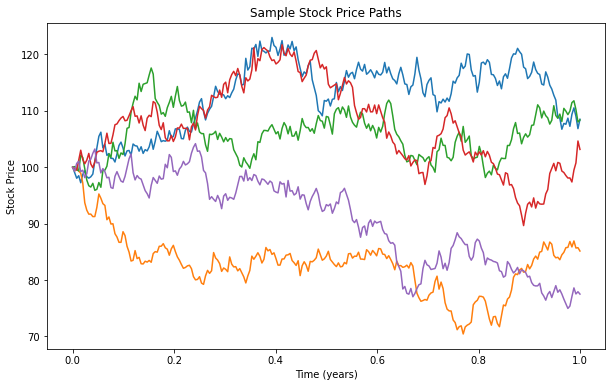

In [7]:
# Parameters
S0 = 100  # Initial stock price
E = 100   # Strike price
T = 1     # Time to maturity (in years)
sigma = 0.2  # Volatility
r = 0.05  # Risk-free rate
dt = 1/252  # Time step (daily)
num_simulations = 100000

# Simulating stock prices
stock_paths, times = simulate_stock_price(S0, r, sigma, T, dt, num_simulations)

# Pricing Asian options
asian_call_payoffs = asian_option_payoff(stock_paths, E, 'call')
asian_put_payoffs = asian_option_payoff(stock_paths, E, 'put')
asian_call_price = price_option(asian_call_payoffs, r, T)
asian_put_price = price_option(asian_put_payoffs, r, T)

# Pricing Lookback options
lookback_call_payoffs = lookback_option_payoff(stock_paths, 'call')
lookback_put_payoffs = lookback_option_payoff(stock_paths, 'put')
lookback_call_price = price_option(lookback_call_payoffs, r, T)
lookback_put_price = price_option(lookback_put_payoffs, r, T)

# Printing results
print(f"Asian Call Option Price: {asian_call_price:.4f}")
print(f"Asian Put Option Price: {asian_put_price:.4f}")
print(f"Lookback Call Option Price: {lookback_call_price:.4f}")
print(f"Lookback Put Option Price: {lookback_put_price:.4f}")

# Plotting a few sample paths
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(times, stock_paths[i])
plt.title("Sample Stock Price Paths")
plt.xlabel("Time (years)")
plt.ylabel("Stock Price")
plt.show()

# Result

| **Option Type** | **Call Option Price** | **Put Option Price** |
|-----------------|-----------------------|----------------------|
| Asian           | 5.7502                | 3.3374               |
| Lookback        | 16.6377               | 13.4662              |


1. **Asian options** are less expensive than their European counterparts due to the averaging effect reducing volatility.

2. **Lookback options** are significantly more expensive, as they provide the optimal payoff over the entire path.

# Observations and Problems

1. **Convergence**: The Monte Carlo simulation converges relatively slowly. Increasing the number of simulations improves accuracy but increases computation time.

2. **Path dependency**: Both Asian and lookback options are path-dependent, requiring us to store and process the entire price path for each simulation. This increases memory usage and computation time compared to simpler European options.

3. **Averaging effect**: Asian options demonstrate how averaging reduces the impact of volatility, resulting in lower option prices compared to standard European options.

4. **Extreme values**: Lookback options capture the most extreme values over the path, leading to significantly higher prices. This reflects the additional optionality they provide.

5. **Discretization error**: The Euler-Maruyama scheme introduces some discretization error. Using a finer time step (smaller \( \Delta t \)) can reduce this error but increases computation time.


In [8]:
# Base parameters
E = 100   # Strike price
r = 0.05  # Risk-free rate
dt = 1/252  # Time step (daily)
num_simulations = 100000

# Parameter variations
S0_values = [80, 100, 120]
sigma_values = [0.15, 0.20, 0.25]
T_values = [0.5, 1, 2]

results = []

for S0 in S0_values:
    for sigma in sigma_values:
        for T in T_values:
            result = run_simulation(S0, E, T, sigma, r, dt, num_simulations)
            results.append(result)

df_results = pd.DataFrame(results)
    
pd.set_option('display.float_format', '{:.4f}'.format)
df_results

,S0,E,T,sigma,r,Asian Call,Asian Put,Lookback Call,Lookback Put
0,80,100,0.5000,0.1500,0.0500,0.0002,18.5323,7.1233,5.5357
1,80,100,1.0000,0.1500,0.0500,0.0344,17.1247,10.6512,7.5603
2,80,100,2.0000,0.1500,0.0500,0.4066,14.7029,16.0527,9.9399
3,80,100,0.5000,0.2000,0.0500,0.0131,18.5471,9.0669,7.7191
4,80,100,1.0000,0.2000,0.0500,0.1948,17.2785,13.2999,10.7518
5,80,100,2.0000,0.2000,0.0500,1.0958,15.4339,19.5425,14.5847
6,80,100,0.5000,0.2500,0.0500,0.0733,18.5692,10.9781,10.0210
7,80,100,1.0000,0.2500,0.0500,0.5408,17.5926,15.9688,14.0988
8,80,100,2.0000,0.2500,0.0500,1.9987,16.3802,22.8026,19.5206
9,100,100,0.5000,0.1500,0.0500,3.0533,1.8347,8.8938,6.9151


# Observation after varying the data 

1. **Effect of Initial Stock Price (S₀)**:
   - As \( S₀ \) increases, call option prices increase while put option prices decrease.
   - This effect is more pronounced for lookback options compared to Asian options.

2. **Effect of Volatility (σ)**:
   - Higher volatility leads to higher option prices for both calls and puts.
   - The impact of volatility is more significant for lookback options than for Asian options.

3. **Effect of Time to Expiry (T)**:
   - Longer time to expiry generally increases option prices for both types and both calls and puts.
   - The effect is more dramatic for lookback options, as they have more opportunity to capture extreme values over a longer period.

4. **Comparison between Asian and Lookback Options**:
   - Lookback options are consistently more expensive than Asian options.
   - The price difference between lookback and Asian options increases with volatility and time to expiry.

5. **Put-Call Parity**:
   - For Asian options, the put-call parity approximately holds (small differences due to Monte Carlo error).
   - For lookback options, put-call parity does not hold in the same way due to their different payoff structures.

6. **In-the-money vs Out-of-the-money**:
   - When \( S₀ < E \) (out-of-the-money for calls), put options are more valuable.
   - When \( S₀ > E \) (in-the-money for calls), call options are more valuable.
   - This effect is more pronounced for Asian options than for lookback options.


# Conclusions

1. This **Monte Carlo simulation** effectively prices Asian and lookback options, demonstrating the significant differences in their values compared to standard options. The method is flexible and can be easily adapted to other exotic options or more complex underlying processes.

2. The results highlight how **path dependency** and different payoff structures impact option prices. Asian options, by averaging prices, reduce the impact of volatility and thus have lower prices. Lookback options, by capturing optimal prices over the entire path, command a significant premium.

3. **Lookback options** are significantly more expensive than Asian options, reflecting the additional optionality they provide.

4. Both option types are sensitive to changes in **volatility** and **time to expiry**, but lookback options show greater sensitivity.

5. **Asian options** provide a more stable pricing structure across different market conditions compared to lookback options.

6. The **averaging effect** in Asian options reduces the impact of volatility, making them less expensive and potentially more suitable for certain risk management strategies.

7. **Lookback options** become particularly valuable in high-volatility or long-term scenarios, where the potential for capturing extreme values is greatest.


# Further Improvement

1. Can implement **variance reduction techniques** to improve convergence.

2. Can use more advanced **numerical schemes** to reduce discretization errors.

3. Can **Parallelize the simulations** to improve performance on multi-core systems.


# References

1. Hull, J. C. (2018). *Options, Futures, and Other Derivatives* (10th ed.). Pearson.

2. **CQF** Lectures, Labs, and Tutorials.
